dx=0.0100, dt=2.0000e-03, nt=501, nu=0.01
Desired frames=200, snapshot interval=2, actual frames=251

--- Conservative Upwind (Godunov-like) Scheme ---


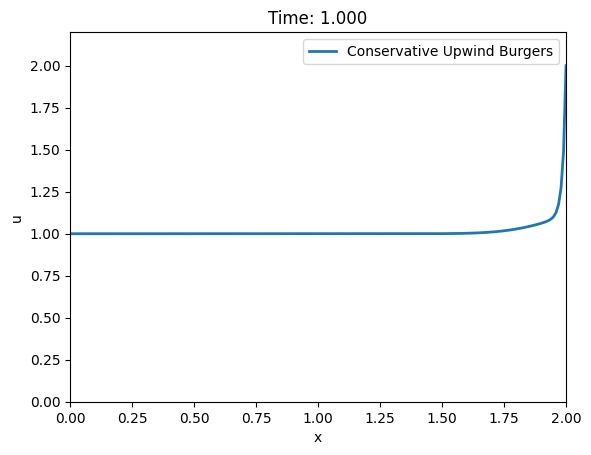

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# -----------------
# Parameters
# -----------------
nx = 201
L = 2.0
x = np.linspace(0, L, nx)
dx = x[1] - x[0]
CFL = 0.4 # More restrictive CFL generally for upwind (or Godunov)
flow_time = 0.3
nu = 0.01  # viscosity; set 0 for inviscid

# Initial condition: low to high
u0 = np.ones_like(x) * 1.0 # Start with a low value everywhere
u0[x >= 0.5*L] = 2.0      # Set the right half to a high value
u = u0.copy()

# Define the flux function for Burgers' equation
def F(u_val):
    return 0.5 * u_val**2

umax = np.max(np.abs(u0))
dt_adv = CFL * dx / umax if umax > 0 else np.inf
dt_diff = 0.5 * dx**2 / nu if nu > 0 else np.inf
dt = min(dt_adv, dt_diff)
nt = int(flow_time / dt) + 1

print(f"dx={dx:.4f}, dt={dt:.4e}, nt={nt}, nu={nu}")

# -----------------
# Control number of frames
# -----------------
desired_frames = 200
snapshot_interval = max(nt // desired_frames, 1)
frame_times = np.arange(0, nt, snapshot_interval)
actual_frames = len(frame_times)
print(f"Desired frames={desired_frames}, snapshot interval={snapshot_interval}, actual frames={actual_frames}")

# -----------------
# Set up the figure
# -----------------
fig, ax = plt.subplots()
line, = ax.plot(x, u0, lw=2, label='Conservative Upwind Burgers')
ax.set_xlim(0, L)
ax.set_ylim(0, 2.2)
ax.set_xlabel("x")
ax.set_ylabel("u")
title = ax.set_title("Time: 0.000")
ax.legend()

# -----------------
# Time-stepping function (Conservative Upwind / Godunov)
# -----------------
def update_conservative_upwind(frame_idx):
    global u
    for _ in range(snapshot_interval):
        un = u.copy()

        # Calculate numerical fluxes at cell interfaces (i+1/2)
        # F_flux[i] will be F_{i+1/2}
        F_flux = np.zeros(nx - 1) # N-1 interfaces for N points

        for i in range(nx - 1):
            u_L = un[i]
            u_R = un[i+1]

            if u_L <= u_R: # Rarefaction or stationary point
                # In a rarefaction, the wave spreads. The flux is F(u_star)
                # where u_star is the intermediate state. For Burgers,
                # if u_L <= u_R, the solution is a rarefaction, and F_{i+1/2} = F(u_L) if u_L >= 0, F(u_R) if u_R <= 0, and 0 if u_L <= 0 <= u_R.
                # A simpler "minmod-like" choice for the conservative upwind flux
                # for rarefactions (u_L < u_R) often uses F(u_L) if u_L > 0, F(u_R) if u_R < 0, else 0 (for transonic).
                # The Godunov flux for Burgers at a rarefaction interface is:
                if u_L >= 0:
                    F_flux[i] = F(u_L)
                elif u_R <= 0:
                    F_flux[i] = F(u_R)
                else: # u_L < 0 and u_R > 0, and a transonic rarefaction forms
                    F_flux[i] = 0.0 # F(0) = 0.5 * 0^2 = 0
            else: # u_L > u_R, potential shock formation
                # Shock speed (Rankine-Hugoniot)
                s = 0.5 * (u_L + u_R)
                if s >= 0: # Shock moves right or is stationary at interface
                    F_flux[i] = F(u_L)
                else: # Shock moves left
                    F_flux[i] = F(u_R)


        # Update u using the conservative form: u_i^{n+1} = u_i^n - (dt/dx) * (F_{i+1/2}^n - F_{i-1/2}^n)
        # This update is for interior points (1 to nx-2)
        u[1:-1] = un[1:-1] - (dt / dx) * (F_flux[1:] - F_flux[:-1])

        # Add diffusion term (central second order, same as before)
        if nu > 0:
            d2udx2 = (un[2:] - 2*un[1:-1] + un[:-2]) / dx**2
            u[1:-1] += nu * dt * d2udx2

        # Boundary conditions: fixed
        u[0] = u0[0]
        u[-1] = u0[-1]

    line.set_ydata(u)
    time = frame_times[frame_idx] * dt
    title.set_text(f"Time: {time:.3f}")
    return line, title

ani_cu = FuncAnimation(fig, update_conservative_upwind, frames=actual_frames, interval=30, blit=True)

# -----------------
# Save animation to HTML5
# -----------------
html_anim_cu = ani_cu.to_html5_video()
print("\n--- Conservative Upwind (Godunov-like) Scheme ---")
HTML(html_anim_cu)